# GET DATA FOR TRAINING

0. --------------------- USING TENSORFLOW FORMAT ---------------------  
1. X: (22750, 1, 33, 33)  y: (22750, 1089)
1. X_train: (22750, 1, 33, 33)  y_train: (22750, 1089)
1. X_test: (0, 1, 33, 33)  y_test: (0, 1089)


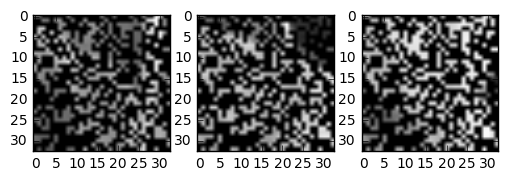

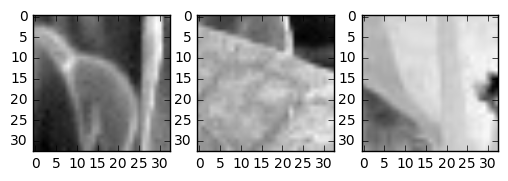

In [1]:
import sys
import os

%matplotlib inline
sys.path.append(os.path.dirname(os.getcwd()))

import utils
X_train, y_train, X_test, y_test = utils.get_data(33, 33, 'tensorflow', 'mr40', 0.0)

# utils.check_gpu(1)

#THIS CELL SELECTS A GOOD RANDOM IMAGES WHOSE RECONSTRUCTION STORY CAN BE WELL UNDERSTOOD

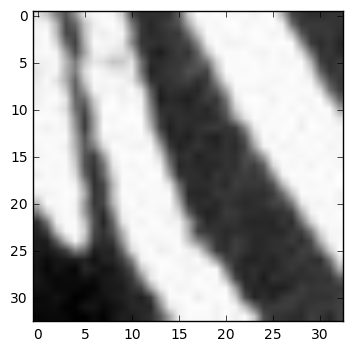

In [16]:
import numpy as np
rand_idx = np.random.randint(0, len(y_train))
plt.imshow(y_train[rand_idx].reshape(33,33), cmap = plt.cm.gray)

# THIS CELL TRAINS


 -------------------------- EPOCH: 15 / 20  -------------------------- 
1.2 Generating fake images via generator model


KeyboardInterrupt: 

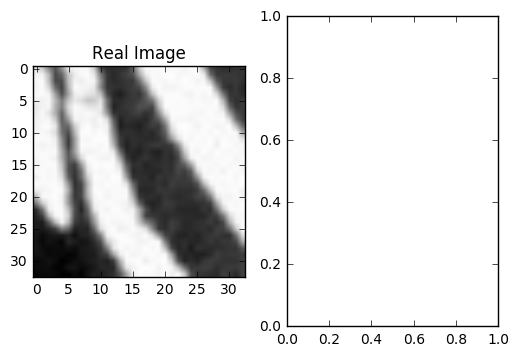

In [18]:
def generator_structure(loss = 'mean_squared_error', model_filename_weights = '', summary = 0):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Convolution2D, MaxPooling2D
    
    model = Sequential()
    
    model.add(Convolution2D(64, kernel_size=(11, 11), activation='relu', use_bias = True
                                , input_shape=(1,33,33), data_format='channels_first', padding='same'))
    
    model.add(Convolution2D(32, kernel_size=(1, 1), activation='relu', use_bias = True, padding='same'))

    model.add(Convolution2D(1, kernel_size=(7, 7), activation='relu', use_bias = True, padding='same'))
    
    model.add(Flatten())
    
    #model.add(Dense(33*33), activation = 'sigmoid)
    
    ##  At the output layer we add a tf.sigmoid() activation function;
    ## this squeezes pixels that would appear grey toward either black or white, resulting in a crisper image.
    
    if model_filename_weights == '':
        pass
    else:
        model.load_weights(model_filename_weights)

    
    model.compile(loss=loss, optimizer='adam',metrics=['accuracy'])

    if summary : model.summary()
    
    return model

def discriminator_structure(model_filename_weights = '', summary = 0):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Convolution2D, MaxPool2D
    
    model = Sequential()
    
    model.add(Convolution2D(4, kernel_size=(4, 4), activation='relu', use_bias = True
                                , input_shape=(1,33,33), data_format='channels_first'))
    
    model.add(Convolution2D(4, kernel_size=(4, 4), activation='relu', use_bias = True))

    model.add(Convolution2D(4, kernel_size=(4, 4), activation='relu', use_bias = True))
    
    model.add(Flatten())
    # model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='relu'))

    if model_filename_weights == '':
        pass
    else:
        model.load_weights(model_filename_weights)
    
    opt = 'adam' #keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    
    if summary : model.summary()
    
    return model

if __name__ == "__main__":
    
    import os
    import numpy as np
    import scipy.misc
    from glob import glob
    import tensorflow as tf
    from time import sleep
    from keras import losses
    from tqdm import tqdm_notebook
    from keras.utils import np_utils
    import matplotlib.pyplot as plt
    from keras import backend as K
    from IPython.core.display import clear_output
    from keras.callbacks import ModelCheckpoint
    
    # np.random.seed(7)
    %matplotlib inline
    
    if utils.check_gpu(0):
        
        """ PARAMS """
        WIDTH = 33 
        HEIGHT = 33
        EPOCHS = 20
        EPOCHS_DIS = 2
        EPOCHS_GEN = 10
        BATCH_SIZE = 128
        MODEL_FOLDER = 'model_mr40'

        """ GENERATOR NETWORK TRAINING DATA """
        X_train_model_gen = X_train.astype('float32')
        X_train_model_gen /= 255
        y_train_model_gen = y_train.astype('float32')
        y_train_model_gen /= 255
        # rand_idx = np.random.randint(0, len(X_train_model_gen))
        
        """ CHECKPOINTS FOR GENERATOR AND DISCRIMINATOR MODELS """
        model_gen_filename_weights = MODEL_FOLDER + "/index_network_gan_gen_keras_weights_{epoch:02d}.hdf5"
        checkpoint_gen = ModelCheckpoint(model_gen_filename_weights, monitor='val_acc', mode='auto'
                                         , save_best_only = False
                                         , save_weights_only = True, verbose=0)
        callbacks_list_gen = [checkpoint_gen]
        
        model_dis_filename_weights = MODEL_FOLDER + "/index_network_gan_dis_keras_weights_{epoch:02d}_{acc:.2f}.hdf5"
        checkpoint_dis = ModelCheckpoint(model_dis_filename_weights, monitor='val_acc', mode='auto'
                                         , save_best_only = False
                                         , save_weights_only = True, verbose=0)
        callbacks_list_dis = [checkpoint_dis]
        
        model_gen_filename_weights_best = sorted(glob(MODEL_FOLDER + '/index_network_gan_gen_keras_weights_*')
                                             , key=os.path.getmtime)[-1]
        model_dis_filename_weights_best = sorted(glob(MODEL_FOLDER + '/index_network_gan_dis_keras_weights_*')
                                             , key=os.path.getmtime)[-1]
        
        
        """ GET THE MODEL STRUCTURES """
        model_gen = generator_structure(model_filename_weights = model_gen_filename_weights_best)
        model_dis = discriminator_structure(model_filename_weights = model_dis_filename_weights_best)

        for epoch in range(EPOCHS):
            print ('\n -------------------------- EPOCH:', epoch + 1, '/', EPOCHS,' -------------------------- ')
            f, axarr = plt.subplots(1,2)
            # rand_idx = np.random.randint(0, len(X_train_model_gen))
            
            """ 1.1 DISCRIMINATOR NETWORK TRAINING DATA """
            X_train_model_dis_real = np.array(y_train_model_gen).reshape((y_train_model_gen.shape[0], 1, WIDTH, HEIGHT))
            y_train_model_dis_real = np.ones((1, len(X_train_model_dis_real)))
            y_train_model_dis_real = np_utils.to_categorical(y_train_model_dis_real, 2)
            # print ('Discriminator Data: X_train_model_dis', X_train_model_dis_real.shape, ' y_train_model_dis:', y_train_model_dis_real.shape)
            axarr[0].imshow(X_train_model_dis_real[rand_idx][0], cmap = plt.cm.gray)
            axarr[0].set_title('Real Image')
            
            """ 1.2 GENERATE FAKE IMAGES """
            print ('1.2 Generating fake images via generator model')
            X_train_model_dis_fake = []
            y_train_model_dis_fake = []
            with tqdm_notebook(total = len(X_train_model_gen), leave = False, desc = 'Fake') as pbar:
                for i, each in enumerate(X_train_model_gen):
                    pbar.update(1)
                    each_tmp = each.reshape(1,1,WIDTH, HEIGHT)
                    X_train_model_dis_fake.append(model_gen.predict(each_tmp))
                    y_train_model_dis_fake.append(0)
            
            X_train_model_dis_fake = np.array(X_train_model_dis_fake).reshape(
                                                (len(X_train_model_dis_fake), 1, WIDTH, HEIGHT))
            axarr[1].imshow(X_train_model_dis_fake[rand_idx][0], cmap = plt.cm.gray)
            axarr[1].set_title('Fake Image')
            plt.show()
            X_train_model_dis = np.vstack((X_train_model_dis_real, np.array(X_train_model_dis_fake)))
            y_train_model_dis_fake = np_utils.to_categorical(y_train_model_dis_fake, 2)
            y_train_model_dis = np.vstack((y_train_model_dis_real, y_train_model_dis_fake))
            print ('1.2 Discriminator Data: X_train_model_dis', X_train_model_dis.shape, ' y_train_model_dis:', y_train_model_dis.shape)

            """ 1.3 TRAIN THE DISCRIMINATOR ON THE `FAKE` + `REAL` IMAGES OF GENERATOR """
            print ('1.3 Training the discriminator model on fake vs real images .... ')
            history = model_dis.fit(X_train_model_dis, y_train_model_dis, batch_size = BATCH_SIZE, epochs = EPOCHS_DIS
                            , shuffle = True
                            , validation_split = 0.1
                            , callbacks = callbacks_list_dis
                            , verbose = 0)
            print ('1.3 Discriminator Model: Acc:', history.history['acc'][-1], ' Loss:', history.history['loss'][-1])
            
            """ 1.4 GENERATE A CUSTOM LOSS FUNCTION OF TENSORFLOW USING FAKE IMAGES AND ASSOCIATED LOSS """
            y_predict_model_dis_fake = []
            print ('1.4 Predicting with discriminator model to generate loss value')
            with tqdm_notebook(total = len(X_train_model_dis_fake), leave = False, desc = 'Loss') as pbar:
                for i, each in enumerate(X_train_model_dis_fake):
                    pbar.update(1)
                    y_predict_model_dis_fake_tmp = model_dis.predict(each.reshape((1, 1, WIDTH, HEIGHT)))
                    y_predict_model_dis_fake.append(y_predict_model_dis_fake_tmp[0])
                        
                y_predict_model_dis_fake = np.array(y_predict_model_dis_fake)
                model_dis_loss_fake = losses.categorical_crossentropy(
                                        K.variable(y_train_model_dis_fake, dtype='float32')
                                        , K.variable(y_predict_model_dis_fake, dtype='float32')
                                    )
                model_dis_loss_fake = float(np.sum(K.eval(model_dis_loss_fake)))
                model_dis_loss_fake /= len(X_train_model_dis_fake)
            
            def custom_model_gen_loss(y_true, y_pred):
                # batch_size = K.variable(int(K.shape(y_true).shape[0]))
                # model_gen_loss_normalized = tf.divide(model_gen_loss, batch_size)
                model_gen_loss = tf.add(losses.mean_squared_error(y_true, y_pred), model_dis_loss_fake)
                return model_gen_loss
            
            """ 1.5 TRAIN THE GENERATOR USING PHI AND INCORPORATE THE DISRIMINATOR LOSS IN TRAINING  """
            print ('1.5 Training the generator model with custom loss')
            model_gen_loss = 'mean_squared_error'
            model_gen_loss = custom_model_gen_loss
            model_gen = generator_structure(model_gen_loss)
            print ('1.5 Generator Data: X_train_model_gen', X_train_model_gen.shape, ' y_train_model_gen:', y_train_model_gen.shape)
            model_gen.fit(X_train_model_gen, y_train_model_gen, batch_size = BATCH_SIZE, epochs = EPOCHS_GEN
                          , shuffle = True
                          , validation_split = 0.0
                          , callbacks = callbacks_list_gen
                          , verbose = 1)
            
            
            if epoch == 0:
                name = MODEL_FOLDER + '/tests/idx_%d_epoch_%d_real' % (rand_idx, epoch) + '.jpg'
                scipy.misc.imsave(name, X_train_model_dis_real[rand_idx][0])
            name = MODEL_FOLDER + '/tests/idx_%d_epoch_%d_fake' % (rand_idx, epoch) + '.jpg'
            scipy.misc.imsave(name, X_train_model_dis_fake[rand_idx][0])
            
            print ('Sleeping...')
            sleep(5)
            clear_output(wait=True)
            
    else:
        print ('Oops! No GPU !!')

# THIS CELL IS FOR EXPERIMENTATION OF LOSS FUNCTIONS

In [ ]:
import numpy as np
import tensorflow as tf
from keras import backend as K

def custom_model_gen_loss(y_true, y_pred):
    model_gen_loss = tf.add(losses.mean_squared_error(y_true, y_pred), model_dis_loss_fake)
    batch_size = K.variable(int(K.shape(y_true).shape[0]))
    
    model_gen_loss_normalized = tf.divide(model_gen_loss, batch_size)
    
    return model_gen_loss_normalized

shape = (100,2)
y_true = np.random.random(shape)
y_pred = np.random.random(shape)
out = K.eval(custom_model_gen_loss(K.variable(y_true), K.variable(y_pred)))
# out1 = K.eval(losses.categorical_crossentropy(K.variable(y_true), K.variable(y_pred)))

# THIS CELL IS FOR EXPERIMENTATION